In [ ]:
library(ComplexHeatmap)
library(ggplot2)
library(Seurat)
library(Matrix)
library(ggpubr)
library(RColorBrewer)
library(circlize)
library(data.table)
library(dplyr)
library(tidyr)


library(miQC)
library(flexmix)

library(infercnv)
library(stringr)
library(GenomicRanges)
library(mixtools)

library(GenomicDataCommons)
library(TCGAbiolinks)

library(survminer)
library(survival)

library(GEOquery)
library(stringr)
library(DESeq2)
library(fgsea)
library(DoubletFinder)
library(rtracklayer)

library(biomaRt)

compute_dead_probability <- function(obj) {
    obj$subsets_mito_percent <- PercentageFeatureSet(obj, pattern = "^MT-")

    obj$detected <- obj$nFeature_RNA
    model <- miQC::mixtureModel( as.SingleCellExperiment(obj) )
    intercept1 <- flexmix::parameters(model, component = 1)[1]
    intercept2 <- flexmix::parameters(model, component = 2)[1]
    if (intercept1 > intercept2) {
        compromised_dist <- 1
        intact_dist <- 2
    } else {
        intact_dist <- 1
        compromised_dist <- 2
    }

    post <- posterior(model)
    prob_compromised <- post[, compromised_dist]
    obj$prob_dead_cell <- prob_compromised
    obj$detected <- NULL
    obj$percent.mt <- obj$subsets_mito_percent
    obj$subsets_mito_percent <- NULL

    return(obj)
}


score_doublets <- function(obj,split.by="orig.ident") {
    
    obj_list <- SplitObject(obj,split.by="orig.ident")
    merged_obj <- NULL
    
    for (obj_name in names(obj_list)) {
        obj <- obj_list[[obj_name]]
        obj <- NormalizeData(obj) %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=10) %>% 
        RunUMAP(.,dims=1:10) %>% FindNeighbors %>% FindClusters(.,dims=1:10)

        sweep.res.list <- paramSweep_v3(obj, PCs = 1:10, sct = FALSE)
        sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
        bcmvn <- find.pK(sweep.stats)
        best_pK <- head(arrange(bcmvn,-BCmetric),1) %>% pull(pK) %>% as.vector %>% as.numeric

        homotypic.prop <- modelHomotypic(obj@meta.data$seurat_clusters)           ## ex: annotations <- seu_kidney@meta.data$ClusteringResults
        nExp_poi <- round(0.08*nrow(obj@meta.data))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
        nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

        obj <- doubletFinder_v3(obj, PCs = 1:10, pN = 0.25, pK = best_pK, 
                        nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

        col_names <- colnames(obj@meta.data)
        pann_col <- col_names[grepl("pANN_",col_names)]
        classification_col <- col_names[grepl("DF.classifications_",col_names)]
        obj$doublet_classification <- obj@meta.data[[classification_col]]
        obj$doublet_pANN <- obj@meta.data[[pann_col]]
        obj[[pann_col]] <- NULL
        obj[["RNA_snn_res.0.8"]] <- NULL
        obj[["seurat_clusters"]] <- NULL
        obj[[classification_col]] <- NULL

        if (is.null(merged_obj)) {
            merged_obj <- obj
        } else {
            merged_obj <- merge(merged_obj,obj)
        }
    }

    return(merged_obj)
}

source("rename_genes.R")

acc_gene_names_df <- fread("/data/Vishaka_Omar/Project/ExtraRawData/Raw_counts/SCAF1780_KrAnACC_Liv_Met/filtered_feature_bc_matrix/features.tsv.gz",header=F)
acc_genes <- acc_gene_names_df$V2

Meta data key : 

`patient_code` : Donor ID

`biopsy_num` : Biopsy number from the patient

`cluster` : Cell type name

`sample_type` : Normal for all healthy tissue donors

`site` : Lung or liver

`percent.mt, subsets_mito_percent` : Percentage of mitochondrial reads

`prob_dead_cell` : Probability that cell is dead based on miQC estimate

`published_anno` : Annotation according to the original study

`method` : Sequencing method used

`sub_site` : Location within organ site

`sex` : Biological sex of donor

# Lung

## Tabula sapiens

In [ ]:
base_path <- "../normal_data/Lung/Tabula Sapiens"
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))
genes <- fread(file.path(base_path,"features.tsv.gz"),header=F) %>% pull(V2)
barcodes <- fread(file.path(base_path,"barcodes.tsv.gz"),header=F) %>% pull(V1)
rownames(mat) <- barcodes
colnames(mat) <- genes
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"))
meta_data_df <- meta_data_dt %>% dplyr::select(cell_id,site=organ_tissue,method,sub_site=anatomical_information,
                              gender,published_anno=cell_ontology_class,patient_code=donor,compartment) %>%
mutate(study="Tabula Sapiens",
       compartment=case_when(compartment == "endothelial" ~ "Endothelial",
                            compartment == "epithelial" ~ "Epithelial",
                            compartment == "immune" ~ "Immune",
                            compartment == "stromal" ~ "Stromal")) %>%
tibble::column_to_rownames("cell_id")

In [ ]:
base_path <- "../normal_data/Lung/Tabula Sapiens"

meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"))


In [ ]:
ts_lung_obj <- CreateSeuratObject(t(mat),meta.data=meta_data_df)
ts_lung_obj$orig.ident <- ts_lung_obj$patient_code

genes_to_keep <- names(which(rowMeans( ts_lung_obj[["RNA"]]@data > 0) > 0.01))

ts_lung_obj <- compute_dead_probability(ts_lung_obj)
prob_dead_threshold <- 0.4
ts_lung_obj <- subset(ts_lung_obj,features=genes_to_keep,subset=prob_dead_cell < prob_dead_threshold)
obj <- rename_seurat_object_genes(ts_lung_obj,acc_genes)

rm(ts_lung_obj)
saveRDS( obj$obj, file.path(base_path,"Seurat_Object.rds") )

ts_lung_obj <- obj$obj
rm(obj)

## Watanabe et. al, 2019

In [ ]:
base_path <- "../normal_data/Lung/Watanabe 2022/"
#For downloading original Seurat object, run "wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE173nnn/GSE173896/suppl/GSE173896%5FCOPD%2Erds%2Egz"
watanabe_obj <- readRDS(file.path(base_path,"GSE173896_COPD.rds"))
merged_df <- merge( tibble::rownames_to_column(watanabe_obj@meta.data,"cell.name"),
                           tibble::enframe( Idents(watanabe_obj), name="cell.name", value="published_anno" ) %>%
mutate(published_anno=as.character(published_anno)), by="cell.name" ) %>%
tibble::column_to_rownames("cell.name")
watanabe_obj <- AddMetaData(watanabe_obj,merged_df)
meta_data_df <- watanabe_obj@meta.data %>% 
mutate(published_anno=case_when(published_anno == "Nerutrophil" ~ "Neutrophil",
                           published_anno == "Adventitail Fibroblast" ~ "Adventitial Fibroblast",
                           TRUE ~ published_anno)) %>%
mutate(compartment=case_when(published_anno %in% c("CD4 Tcell","NK","NKT","CD8 M/E Tcell-1","CD8 M/E Tcell-2","Neutrophil",
                                              "Bcell","Proliferating Immunecell","B plasma","Basophil") ~ "Lymphoid",
                            grepl("^VE-",published_anno) | published_anno == "Pericyte/SMA" ~ "Endothelial",
                            published_anno %in% c("Macrophage-1","Macrophage-2","cMonocyte","pDC","MAST") ~ "Myeloid",
                            published_anno %in% c("AT2-1","AT1","AT2-2","AT2-3","Ciliated","Basal/Club") ~ "Epithelial",
                            published_anno %in% c("Alveolar Fibroblast","Adventitial Fibroblast","Myofibroblast") ~ "Stromal")) #%>%
# dplyr::count(compartment,published_anno)
watanabe_obj <- AddMetaData(watanabe_obj,meta_data_df)
non_smoker_watanabe_obj <- subset(watanabe_obj,subset = Class != "Smoker") %>% DietSeurat
temp <- rename_seurat_object_genes( non_smoker_watanabe_obj, acc_genes )
non_smoker_watanabe_obj <- temp$obj
rm(watanabe_obj)

non_smoker_watanabe_obj$sex <- non_smoker_watanabe_obj$Gender
non_smoker_watanabe_obj$age <- non_smoker_watanabe_obj$Age
non_smoker_watanabe_obj$patient_code <- non_smoker_watanabe_obj$orig.ident
non_smoker_watanabe_obj$site <- "Lung"
non_smoker_watanabe_obj$study <- "Watanabe_etal_2022"
cols_to_keep <- c("sex","age","patient_code","site","orig.ident",
                 "nCount_RNA","percent.mt","nFeature_RNA","published_anno","compartment")
cols_to_remove <- setdiff( colnames(non_smoker_watanabe_obj@meta.data), cols_to_keep )
for (col in cols_to_remove) {
    non_smoker_watanabe_obj[[col]] <- NULL
}
non_smoker_watanabe_obj$sex <- ifelse(non_smoker_watanabe_obj$sex == "Male","M","F")

non_smoker_watanabe_obj <- score_doublets(non_smoker_watanabe_obj,split.by = "orig.ident")

saveRDS( non_smoker_watanabe_obj, file.path( base_path, "Seurat_Object.rds" ) )

## Deprez et. al 2020

In [ ]:
base_path <- "../normal_data/Lung/Deprez 2020"
meta_data_dt <- fread(file.path(base_path,"meta.tsv"))
dt <- fread(file.path(base_path,"Raw_exprMatrix_grch38.tsv.gz"))
mat <- tibble::column_to_rownames(dt,"Gene") %>% as.matrix %>% as(.,"dgCMatrix")
rm(dt)

meta_data_df <- meta_data_dt %>% dplyr::select(Id,patient_code=Donor,biopsy_num=Sample,
                              sub_site=Position,percent.mt=`Percent.Mitochond.`,
                              published_anno=CellType,sex=Sex,age=Age) %>%
mutate(orig.ident=patient_code) %>% tibble::column_to_rownames("Id")
deprez_obj <- CreateSeuratObject(mat,meta.data = meta_data_df)
deprez_obj$percent.mt <- 100*deprez_obj$percent.mt
deprez_obj$study <- "Deprez_etal_2020"


subset_deprez_obj <- subset(deprez_obj,subset = sub_site == "Intermediate" & percent.mt < 20)
subset_deprez_obj$sex <- ifelse(subset_deprez_obj$sex == "male","M","F")
subset_deprez_obj$site <- "Lung"

meta_data_df <- subset_deprez_obj@meta.data %>% 
mutate(compartment=case_when(published_anno %in% c("B cells","LT/NK","Plasma cells") ~ "Lymphoid",
                                                  published_anno %in% c("Dendritic","Macrophage","Monocyte","Mast cells") ~ "Myeloid",
                                                  published_anno %in% c("Endothelial","Pericyte") ~ "Endothelial",
                                                  published_anno %in% c("Fibroblast") ~ "Stromal",
                                                  TRUE ~ "Epithelial"))
subset_deprez_obj <- AddMetaData(subset_deprez_obj,meta_data_df)

temp <- rename_seurat_object_genes(subset_deprez_obj,acc_genes)
subset_deprez_obj <- temp$obj
# rm(temp)
saveRDS( subset_deprez_obj, file.path( base_path, "Seurat_Object.rds" ) )

## Conde et al 2022

In [ ]:
base_path <- "../normal_data/Lung/Conde 2022"
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"),header=T)

In [ ]:
base_path <- "../normal_data/Lung/Conde 2022"
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"),header=T)
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))
genes <- fread(file.path(base_path,"features.tsv.gz"),header=F) %>% pull(V1)
barcodes <- meta_data_dt$V1
rownames(mat) <- barcodes
colnames(mat) <- genes

meta_data_df <- meta_data_dt %>% dplyr::select(V1,site=Organ,patient_code=Donor,published_anno=Majority_voting_CellTypist_high,sex=Sex) %>%
mutate(orig.ident=patient_code) %>% tibble::column_to_rownames("V1")
v3_cells <- meta_data_dt %>% dplyr::filter(Chemistry == "3") %>% pull(V1)

conde_obj <- CreateSeuratObject(t(mat),meta.data=meta_data_df,project.name="Conde_etal_2022")
conde_obj$subsets_mito_percent <- PercentageFeatureSet(conde_obj, pattern = "^MT-")
conde_obj <- compute_dead_probability(conde_obj)
subset_conde_obj <- subset( conde_obj, 
                           subset = site %in% c("LNG") & prob_dead_cell < 0.4 ) %>%
subset(.,cells = v3_cells)
subset_conde_obj$study <- "Conde_etal_2022"

source("rename_genes.R")
temp <- rename_seurat_object_genes(subset_conde_obj,acc_genes)
subset_conde_obj <- temp$obj

meta_data_df <- subset_conde_obj@meta.data %>%
mutate(compartment=case_when(published_anno %in% c("DC","pDC","Monocytes","Macrophages","Mast cells","Promyelocytes","HSC/MPP") ~ "Myeloid",
                              published_anno %in% c("T cells","Plasma cells","B cells","ILC","Cycling cells") ~ "Lymphoid"))    
subset_conde_obj <- AddMetaData(subset_conde_obj,meta_data_df)
rm(temp)

subset_conde_obj$sex <- ifelse(subset_conde_obj$sex == "Male","M","F")
subset_conde_obj <- score_doublets(subset_conde_obj,split.by = "orig.ident")

saveRDS( subset_conde_obj, file.path( base_path, "Seurat_Object.rds" ) )

In [ ]:
base_path <- "../normal_data/Lung/Conde 2022"
saveRDS( subset_conde_obj, file.path( base_path, "Seurat_Object.rds" ) )

## Vieira Braga 2019 (Not used/run)

In [ ]:
base_path <- "../normal_data/Lung/Vieira Braga 2019/Alveoli Parenchyma/"
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"))
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))

In [ ]:
temp <- fread("../normal_data/Lung/Vieira Braga 2019/GSE130148_raw_counts.csv.gz")
meta_data_dt <- fread("../normal_data/Lung/Vieira Braga 2019/GSE130148_barcodes_cell_types.txt.gz")

## Merging lung data together

In [ ]:
subset_watanabe_obj <- readRDS("../normal_data/Lung/Watanabe 2022/Seurat_Object.rds")
subset_conde_obj <- readRDS("../normal_data/Lung/Conde 2022/Seurat_Object.rds")
subset_deprez_obj <- readRDS("../normal_data/Lung/Deprez 2020/Seurat_Object.rds")


# 4 + ""
merged_lung_obj <- merge( subset(subset_watanabe_obj,subset = doublet_classification == "Singlet"),
                         subset( subset_conde_obj, subset = doublet_classification == "Singlet") ) %>%
merge(.,subset( subset_deprez_obj, subset = doublet_classification == "Singlet" ) )
merged_lung_obj$site <- "Lung"
saveRDS(merged_lung_obj,"../normal_data/Lung/Merged_Normal_Lung_Seurat_Object.rds")

In [ ]:
saveRDS(subset_watanabe_obj,"../normal_data/Lung/Watanabe 2022/Seurat_Object.rds")
saveRDS(subset_conde_obj,"../normal_data/Lung/Conde 2022/Seurat_Object.rds")
saveRDS(subset_deprez_obj,"../normal_data/Lung/Deprez 2020/Seurat_Object.rds")

In [ ]:
subset_deprez_obj <- score_doublets(subset_deprez_obj,split.by = "orig.ident")

# Liver

## Tabula Sapiens

(Not used)

In [ ]:
base_path <- "../normal_data/Liver/Tabula Sapiens"
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))
genes <- fread(file.path(base_path,"features.tsv.gz"),header=F) %>% pull(V2)
barcodes <- fread(file.path(base_path,"barcodes.tsv.gz"),header=F) %>% pull(V1)
rownames(mat) <- barcodes
colnames(mat) <- genes
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"))
meta_data_df <- meta_data_dt %>% dplyr::select(cell_id,site=organ_tissue,method,sub_site=anatomical_information,
                              gender,published_anno=cell_ontology_class,patient_code=donor,compartment) %>%
mutate(study="Tabula Sapiens",
       compartment=case_when(compartment == "endothelial" ~ "Endothelial",
                            compartment == "epithelial" ~ "Epithelial",
                            compartment == "immune" ~ "Immune",
                            compartment == "stromal" ~ "Stromal")) %>%
tibble::column_to_rownames("cell_id")

In [ ]:
ts_liver_obj <- CreateSeuratObject(t(mat),meta.data=meta_data_df)
ts_liver_obj$orig.ident <- ts_liver_obj$patient_code
genes_to_keep <- names(which(rowMeans( ts_liver_obj[["RNA"]]@data > 0) > 0.01))
ts_liver_obj <- compute_dead_probability(ts_liver_obj)
prob_dead_threshold <- 0.4
ts_liver_obj <- subset(ts_liver_obj,features=genes_to_keep,subset=prob_dead_cell < prob_dead_threshold)
ts_liver_obj <- score_doublets(ts_liver_obj,split.by="orig.ident")
obj <- rename_seurat_object_genes(ts_liver_obj,acc_genes)

rm(ts_liver_obj)
saveRDS( obj$obj, file.path(base_path,"Seurat_Object.rds") )

ts_liver_obj <- obj$obj
rm(obj)

## Conde et al 2022 

(Not used because there are no liver cells found by 10x V3)

In [ ]:
base_path <- "../normal_data/Lung/Conde 2022"
meta_data_dt <- fread(file.path(base_path,"meta.tsv.gz"),header=T)
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))
genes <- fread(file.path(base_path,"features.tsv.gz"),header=F) %>% pull(V1)
barcodes <- meta_data_dt$V1
rownames(mat) <- barcodes
colnames(mat) <- genes

meta_data_df <- meta_data_dt %>% dplyr::select(V1,site=Organ,patient_code=Donor,published_anno=Majority_voting_CellTypist_high,sex=Sex) %>%
mutate(orig.ident=patient_code) %>% tibble::column_to_rownames("V1")
v3_cells <- meta_data_dt %>% dplyr::filter(Chemistry == "3") %>% pull(V1)

conde_obj <- CreateSeuratObject(t(mat),meta.data=meta_data_df,project.name="Conde_etal_2022")
conde_obj$subsets_mito_percent <- PercentageFeatureSet(conde_obj, pattern = "^MT-")
conde_obj <- compute_dead_probability(conde_obj)

## GSE136103

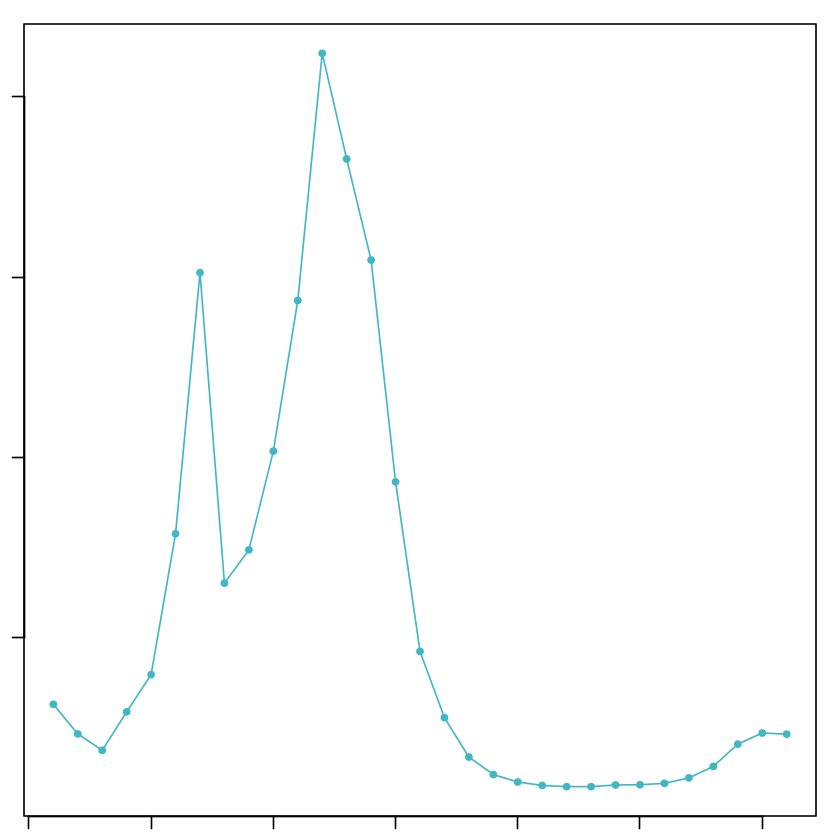

In [ ]:
base_path <- "../normal_data/Liver/GSE136103"

files <- list.files(base_path,full.names=T)
# gsm_files <- str_match(files,"GSM[0-9]*") %>% as.vector %>% unique %>% na.omit
gsm_prefixes <- gsub(".*GSM","GSM",files) %>% gsub("_genes.*gz|_matrix.*gz|_barcodes.*gz","",.) %>% unique 
meta_data_df <- data.frame()
healthy_ids <- c()

temp <- getGEO("GSE136103")
geo_meta_data_df <- pData(temp$`GSE136103-GPL20301_series_matrix.txt.gz`) %>% dplyr::select(sex=`Sex:ch1`,sort_status=`cell subtype:ch1`) %>%
tibble::rownames_to_column("gsm_accession")

liver_obj <- NULL
gsm_prefixes <- gsm_prefixes[!grepl("Seurat_Object",gsm_prefixes)]
for (gsm_prefix in gsm_prefixes[2:length(gsm_prefixes)]) {
    matrix_path <- file.path(base_path,paste(gsm_prefix,"matrix.mtx.gz",sep="_"))
    genes_path <- file.path(base_path,paste(gsm_prefix,"genes.tsv.gz",sep="_"))
    barcodes_path <- file.path(base_path,paste(gsm_prefix,"barcodes.tsv.gz",sep="_"))

    mat <- readMM(matrix_path)
    barcodes <- fread(barcodes_path,header=F) %>% pull(V1)
    genes <- fread(genes_path,header=F) %>% pull(V2)
    colnames(mat) <- barcodes
    rownames(mat) <- genes
    
    healthy_patient_id <- str_match(gsm_prefix,"healthy[0-9]") %>% as.character
    cd45_status <- str_match(gsm_prefix,"cd45[+|-]") %>% as.character %>% gsub("c","C",.)
    healthy_patient_id_with_cd45 <- paste(healthy_patient_id,cd45_status,sep="_")
    biopsy_num <- 1
    if (healthy_patient_id_with_cd45 %in% healthy_ids) {
        num_samples_present <- sum(healthy_ids == healthy_patient_id_with_cd45)
        biopsy_num <- num_samples_present + 1
    }
    healthy_ids <- c(healthy_ids,healthy_patient_id_with_cd45)
    gsm_accession_ <- str_match(gsm_prefix,"GSM[0-9][0-9]*") %>% as.character
    obj <- CreateSeuratObject(mat, project=healthy_patient_id)
    obj$sub_site <- geo_meta_data_df %>% dplyr::filter(gsm_accession==gsm_accession_) %>% pull(sort_status)
    obj$sex <- geo_meta_data_df %>% dplyr::filter(gsm_accession==gsm_accession_) %>% pull(sex)
    obj$sex <- ifelse(obj$sex == "Male","M","F")
    obj$biopsy_num <- biopsy_num
    
     if (is.null(liver_obj)) {
        liver_obj <- obj
    } else {
        liver_obj <- merge(liver_obj,obj)
    }
}

liver_obj$subsets_mito_percent <- PercentageFeatureSet(liver_obj, pattern = "^MT-")
liver_obj <- compute_dead_probability(liver_obj)
liver_obj$site <- "Liver"
liver_obj$sample_type <- "Normal"
liver_obj$study <- "GSE136103"
liver_obj <- subset(liver_obj,subset=prob_dead_cell < 0.4)
liver_obj$sample_ident <- paste(liver_obj$orig.ident,liver_obj$sub_site,liver_obj$biopsy_num,sep="_")
liver_obj <- score_doublets(liver_obj,split.by="sample_ident")
liver_obj$orig.ident <- liver_obj$sample_ident

liver_obj$sample_ident <- NULL

temp <- rename_seurat_object_genes(liver_obj,acc_genes)

saveRDS(temp$obj,file.path(base_path,"Seurat_Object.rds"))

## GSE125188

In [ ]:
base_path <- "../normal_data/Liver/GSE125188"
barcodes <- fread(file.path(base_path,"barcodes.tsv.gz"),header=F) %>% pull(V1)
genes <- fread(file.path(base_path,"features.tsv.gz"),header=F) %>% pull(V1)
meta_data_df <- fread(file.path(base_path,"liver_immune_prohect_annotations.txt"))
mat <- readMM(file.path(base_path,"matrix.mtx.gz"))
colnames(mat) <- barcodes
rownames(mat) <- genes

barcodes_with_empty_info <- fread(file.path(base_path,"barcodes.tsv.gz"),header=F)
non_empty_barcodes = barcodes_with_empty_info %>% dplyr::filter(V2 == 1) %>% mutate(barcode=gsub("-.*","",V1)) %>%
pull(V1)
liver_obj <- CreateSeuratObject(mat[,non_empty_barcodes])
liver_obj <- compute_dead_probability(liver_obj)
liver_obj <- subset(liver_obj,subset=prob_dead_cell < 0.4 & nCount_RNA > 1000)

donor_ids <- paste0("D",gsub(".*-","",rownames(liver_obj@meta.data)))
liver_obj$orig.ident <- donor_ids
liver_obj <- score_doublets(liver_obj)

temp <- rename_seurat_object_genes(liver_obj,acc_genes)


meta_data_df <- temp$obj@meta.data %>% 
mutate(sex="M",
      age=case_when(orig.ident == "D0" ~ 41,
                   orig.ident == "D1" ~ 27,
                   orig.ident == "D2" ~ 56))

temp$obj <- AddMetaData(temp$obj,meta_data_df)


saveRDS(temp$obj,file.path(base_path,"Seurat_Object.rds"))

## GSE189539

In [ ]:
base_path <- "../normal_data/Liver/GSE189539"

dt <- fread(file.path(base_path,"GSE189539_Raw_gene_counts_matrix.csv.gz"))
meta_data_dt <- fread("../normal_data/Liver/GSE189539/celltype.txt")
meta_data_dt <- dplyr::filter(meta_data_dt,condition == "before LT") 
mat <- tibble::column_to_rownames(dt,"V1") %>% as.matrix %>% as(.,"dgCMatrix")
cells_to_keep <- meta_data_dt$cell_id
mat <- mat[,cells_to_keep]
rm(dt)

liver_obj <- CreateSeuratObject(mat,meta.data=tibble::column_to_rownames(meta_data_dt,"cell_id"))
liver_obj <- compute_dead_probability(liver_obj)
liver_obj <- subset(liver_obj,subset = prob_dead_cell < 0.4)
liver_obj <- score_doublets(liver_obj,split.by="group")

temp <- rename_seurat_object_genes(liver_obj,acc_genes)

meta_data_df <- temp$obj@meta.data %>% 
mutate(orig.ident=group) %>% dplyr::select(orig.ident,nCount_RNA,nFeature_RNA,published_anno=celltype,
                                          prob_dead_cell,doublet_classification,doublet_pANN,percent.mt)

cols_to_remove <- setdiff(colnames(temp$obj@meta.data),colnames(meta_data_df))
for (col in cols_to_remove) {
    temp$obj[[col]] <- NULL
}
temp$obj <- AddMetaData(temp$obj,meta_data_df)

meta_data_df <- temp$obj@meta.data %>%
mutate(sex=ifelse(orig.ident %in% c("Pat.1","Pat.2","Pat.4"),"M","F"),
      age=case_when(orig.ident == "Pat.1" ~ 63,
                   orig.ident == "Pat.2" ~ 62,
                   orig.ident == "Pat.3" ~ 65,
                   orig.ident == "Pat.4" ~ 53))

temp$obj <- AddMetaData(temp$obj,meta_data_df)


saveRDS(temp$obj,file.path(base_path,"Seurat_Object.rds"))

## Macparland et al 2018

In [ ]:
source("process_data.R")
base_path <- ".."
nLiver_obj <- load_liver_data()
nLiver_obj$nCount_RNA <- nLiver_obj$total_counts
nLiver_obj$nFeature_RNA <- nLiver_obj$total_features
nLiver_obj$total_counts <- NULL
nLiver_obj$total_features <- NULL

nLiver_obj <- compute_dead_probability(nLiver_obj) %>% subset(.,subset=prob_dead_cell < 0.4)
nLiver_obj <- score_doublets(nLiver_obj,split.by="orig.ident")

temp <- rename_seurat_object_genes(nLiver_obj,acc_genes)
meta_data_df <- temp$obj@meta.data %>%
dplyr::select(orig.ident,nCount_RNA,nFeature_RNA,prob_dead_cell,percent.mt,doublet_classification,doublet_pANN,
             published_anno=celltype)

cols_to_remove <- setdiff(colnames(temp$obj@meta.data),colnames(meta_data_df))
for (col in cols_to_remove) {
    temp$obj[[col]] <- NULL
}
temp$obj <- AddMetaData(temp$obj,meta_data_df)

meta_data_df <- temp$obj@meta.data %>% 
mutate(sex=ifelse(orig.ident %in% c("P1TLH","P2TLH","P4TLH","P5TLH"),"M","F"),
      age=case_when(orig.ident == "P1TLH" ~ 44,
                   orig.ident == "P2TLH" ~ 65,
                   orig.ident == "P3TLH" ~ 41,
                   orig.ident == "P4TLH" ~ 21,
                   orig.ident == "P5TLH" ~ 26))

temp$obj <- AddMetaData(temp$obj,meta_data_df)
saveRDS(temp$obj,"../normal_data/Liver/Macparland et al 2018/Seurat_Object.rds")

## Andrews et. al 2022

In [ ]:
andrews_etal <- readRDS("../normal_data//Liver//Andrews_etal//local.rds")
meta_data_df <- andrews_etal@meta.data %>% dplyr::filter(suspension_type == "cell") %>%
dplyr::select(orig.ident=donor_id,nCount_RNA,nFeature_RNA,published_anno=author_cell_type,
             sex,percent.mt)

andrews_etal <- subset(andrews_etal,subset = suspension_type == "cell")

andrews_etal <- DietSeurat(andrews_etal) %>% subset(.,subset=percent.mt < 25 & nCount_RNA > 1000)

cols_to_remove <- setdiff(colnames(andrews_etal@meta.data),colnames(meta_data_df))
for (col in cols_to_remove) {
    andrews_etal[[col]] <- NULL
}
andrews_etal <- AddMetaData(andrews_etal,meta_data_df)
andrews_etal$sex <- ifelse(andrews_etal$sex == "female","F","M")

In [ ]:
gtf <- rtracklayer::readGFF("Homo_sapiens.GRCh38.107.gtf.gz")

id_to_name_df <- gtf %>% dplyr::filter(gene_id %in% rownames(andrews_etal)) %>%
dplyr::select(gene_id,gene_name) %>% unique %>% na.omit

duplicated_gene_names <- dplyr::count(id_to_name_df,gene_name) %>% dplyr::filter(n>1) %>%
pull(gene_name) %>% unique
duplicated_gene_ids <- dplyr::filter(id_to_name_df,gene_name %in% duplicated_gene_names) %>% pull(gene_id)
non_duplicated_ids <- setdiff(id_to_name_df$gene_id,duplicated_gene_ids) %>% unique
orig_mat <- andrews_etal[["RNA"]]@counts
new_mat <- orig_mat[non_duplicated_ids,]

id_to_name_vec <- dplyr::filter(id_to_name_df,gene_id %in% non_duplicated_ids) %>% tibble::deframe(.)
rownames(new_mat) <- id_to_name_vec[rownames(new_mat)]
duplicated_mat <- NULL
for (gene_name_ in duplicated_gene_names) {
    gene_ids <- dplyr::filter(id_to_name_df,gene_name == gene_name_) %>% pull(gene_id)
    temp_mat <- t(as.matrix(colSums(orig_mat[gene_ids,])))
    if (is.null(duplicated_mat)) {
        duplicated_mat <- temp_mat
    } else {
        duplicated_mat <- rbind(duplicated_mat,temp_mat)
    }
}
rownames(duplicated_mat) <- duplicated_gene_names
duplicated_mat <- as(duplicated_mat,"dgCMatrix")
new_mat <- rbind(new_mat,duplicated_mat)

new_andrews_etal_obj <- CreateSeuratObject(new_mat,meta.data=dplyr::select(andrews_etal@meta.data,-nCount_RNA,-nFeature_RNA))
new_andrews_etal_obj$percent.mt <- PercentageFeatureSet(new_andrews_etal_obj,pattern = "^MT-")

new_andrews_etal_obj <- score_doublets(new_andrews_etal_obj)

temp <- rename_seurat_object_genes(new_andrews_etal_obj,acc_genes)
temp$obj$study <- "Andrews_etal"
saveRDS(temp$obj,"../normal_data//Liver/Andrews_etal/Seurat_Object.rds")

## Merging all liver data together

In [ ]:
gse189539_obj <- readRDS("../normal_data/Liver/GSE189539/Seurat_Object.rds") %>% subset(.,subset=doublet_classification == "Singlet")
gse125188_obj <- readRDS("../normal_data/Liver/GSE125188/Seurat_Object.rds") %>% subset(.,subset=doublet_classification == "Singlet")
gse136103_obj <- readRDS("../normal_data/Liver/GSE136103/Seurat_Object.rds") %>% subset(.,subset=doublet_classification == "Singlet")
macparland_obj <- readRDS("../normal_data/Liver/Macparland et al 2018/Seurat_Object.rds") %>% subset(.,subset=doublet_classification == "Singlet")
andrews_obj <- readRDS("../normal_data/Liver/Andrews_etal/Seurat_Object.rds") %>% subset(.,subset=doublet_classification == "Singlet")

gse189539_obj$study <- "GSE189539"
gse125188_obj$study <- "GSE125188"
gse136103_obj$study <- "GSE136103"
macparland_obj$study <- "Macparland et. al"
andrews_obj$study <- "Andrews et. al"


meta_data_df <- macparland_obj@meta.data %>%
mutate(compartment=case_when(published_anno %in% c("Hep1","Hep2","Hep3","Hep4","Hep5","Hep6",
                                                  "Cholangiocytes") ~ "Epithelial",
                             published_anno %in% c("Alpha-Beta T cells","Gamma-Delta T cells 1",
                                                  "Gamma-Delta T cells 2","Plasma cells","Mature B cells",
                                                  "NK-like cells") ~ "Lymphoid",
                             published_anno %in% c("Central venous LSECs","Periportal LSECs","Portal endothelial cells") ~ "Endothelial",
                             published_anno %in% c("Eryhtroid cells","Inflammatory Macs","Non-inflammatory Macs") ~ "Myeloid",
                             TRUE ~ "Stromal"))
macparland_obj <- AddMetaData(macparland_obj,meta_data_df)

meta_data_df <- 
andrews_obj@meta.data %>%
mutate(compartment=case_when(published_anno %in% c("InterHep","PortalHep","CentralHep","Cholangiocyte") ~ "Epithelial",
                             published_anno %in% c("Bcells","NKTcell") ~ "Lymphoid",
                             published_anno %in% c("cvLSECs","PortalEndo") ~ "Endothelial",
                             published_anno %in% c("Erythroid","InfMac","NonInfMac") ~ "Myeloid",
                             TRUE ~ "Stromal")) #%>% dplyr::count(published_anno,compartment)
andrews_obj <- AddMetaData(andrews_obj,meta_data_df)


merged_liver_obj <- merge(gse189539_obj,gse125188_obj) %>%
merge(.,gse136103_obj) %>% merge(.,macparland_obj) %>% merge(.,andrews_obj)

merged_liver_obj$site <- "Liver"
merged_liver_obj$sample_type <- "Normal"

saveRDS(merged_liver_obj,"../normal_data/Liver/Merged_Normal_Liver_Seurat_Object.rds")